In [1]:
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
%matplotlib inline

import string
import os
import glob
from PIL import Image
from time import time

from keras import Input, layers
from keras import optimizers
from keras.optimizers import Adam
from keras.preprocessing import sequence
from keras.preprocessing import image
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import LSTM, Embedding, Dense, Activation, Flatten, Reshape, Dropout
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.models import Model
from keras.utils import to_categorical

# **Data loading and Preprocessing**

In this project, we will use UIT-ViIC dataset with Vietnamese language. 

In [2]:
train_token_path = "/kaggle/input/uit-viic-v1-0-vietnamese-image-captioning/dataset/train/captions.txt"
val_token_path = "/kaggle/input/uit-viic-v1-0-vietnamese-image-captioning/dataset/val/captions.txt"
test_token_path = "/kaggle/input/uit-viic-v1-0-vietnamese-image-captioning/dataset/test/captions.txt"

train_images = "/kaggle/input/uit-viic-v1-0-vietnamese-image-captioning/dataset/train/images"
val_images = "/kaggle/input/uit-viic-v1-0-vietnamese-image-captioning/dataset/val/images"
test_images = "/kaggle/input/uit-viic-v1-0-vietnamese-image-captioning/dataset/test/images"

train_doc = open(train_token_path, 'r').read()
val_doc = open(val_token_path, 'r').read()
test_doc = open(test_token_path, 'r').read()

print(train_doc[:458])

/dataset/train/images/000000157656.jpg	Người đàn ông đang đánh tennis ngoài sân.
/dataset/train/images/000000157656.jpg	Một vận động viên tennis đang vung vợt đánh bóng.
/dataset/train/images/000000157656.jpg	Một cầu thủ tennis đang vung vợt tennis đỡ bóng.
/dataset/train/images/000000157656.jpg	Người đàn ông đang đứng ngoài biên cầm vợt sẵn sàng đỡ bóng.
/dataset/train/images/000000157656.jpg	Vận động viên tennis nam đang trong tư thế chuẩn bị đỡ bóng.



In [3]:
def format_content(doc):
    descriptions = dict()
    for line in doc.split('\n'):
            tokens = line.split()
            if len(line) > 2:
                image_info = tokens[0].split('/')[-1]
                image_id = image_info.split('.')[0]
                image_desc = ' '.join(tokens[1:])
                if image_id not in descriptions:
                    descriptions[image_id] = list()
                descriptions[image_id].append(image_desc)
    return descriptions

train_descriptions = format_content(train_doc)
val_descriptions = format_content(val_doc)
test_descriptions = format_content(test_doc)

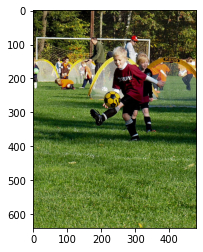

['Trên sân cỏ , một cậu bé đang giơ chân lên để đá quả bóng .',
 'Một cậu bé đang đá quả bóng trong khi một cậu bé khác đang đứng ở phía sau .',
 'Một nhóm người đang chơi đùa trên sân cỏ .',
 'Trên sân cỏ , hai cầu thủ bóng đá đang luyện tập .',
 'Trên sân cỏ , một cầu thủ đang giơ chân lên để đá quả bóng .']

In [4]:
vit_pic = '000000000368.jpg'
x = plt.imread(train_images + '/' + vit_pic)
plt.imshow(x)
plt.show()
train_descriptions['000000000368']

In [5]:
def create_vocab(descriptions, vocab = None):
    if vocab != None:
        vocabulary = vocab
    else:
        vocabulary = set()
    for key in descriptions.keys():
            [vocabulary.update(d.split()) for d in descriptions[key]]
    print('Original Vocabulary Size: %d' % len(vocabulary))
    return vocabulary

vocabulary = create_vocab(train_descriptions)
vocabulary = create_vocab(val_descriptions, vocabulary)

Original Vocabulary Size: 1406
Original Vocabulary Size: 1604


In [6]:
def create_new_description(descriptions, orig=None):
    if orig != None:
        lines = orig
    else:
        lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + ' ' + desc)
    new_descriptions = '\n'.join(lines)
    return new_descriptions

new_train_descriptions = create_new_description(train_descriptions)
new_val_descriptions = create_new_description(val_descriptions)
new_test_descriptions = create_new_description(test_descriptions)

In [7]:
train = set(train_descriptions.keys())
val = set(val_descriptions.keys())
test = set(test_descriptions.keys())

In [8]:
train_img = os.listdir(train_images)
val_img = os.listdir(val_images)
test_img = os.listdir(test_images)

In [9]:
train_img

['000000082091.jpg',
 '000000303548.jpg',
 '000000157593.jpg',
 '000000090572.jpg',
 '000000102451.jpg',
 '000000134454.jpg',
 '000000492417.jpg',
 '000000334283.jpg',
 '000000450477.jpg',
 '000000506550.jpg',
 '000000195851.jpg',
 '000000504091.jpg',
 '000000550444.jpg',
 '000000492840.jpg',
 '000000552254.jpg',
 '000000518916.jpg',
 '000000556216.jpg',
 '000000099336.jpg',
 '000000143346.jpg',
 '000000018688.jpg',
 '000000181278.jpg',
 '000000053081.jpg',
 '000000253251.jpg',
 '000000578226.jpg',
 '000000551633.jpg',
 '000000558808.jpg',
 '000000233968.jpg',
 '000000282147.jpg',
 '000000460491.jpg',
 '000000218294.jpg',
 '000000502776.jpg',
 '000000133060.jpg',
 '000000418772.jpg',
 '000000432432.jpg',
 '000000575135.jpg',
 '000000033429.jpg',
 '000000268293.jpg',
 '000000057461.jpg',
 '000000470832.jpg',
 '000000432873.jpg',
 '000000041962.jpg',
 '000000360762.jpg',
 '000000218116.jpg',
 '000000307967.jpg',
 '000000104417.jpg',
 '000000468284.jpg',
 '000000547300.jpg',
 '00000028944

In [10]:
def add_token(description, id_list):
    descriptions = dict()
    for line in description.split('\n'):
        tokens = line.split()
        image_id, image_desc = tokens[0], tokens[1:]
        if image_id in id_list:
            if image_id not in descriptions:
                descriptions[image_id] = list()
            desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
            descriptions[image_id].append(desc)
    return descriptions

train_descriptions = add_token(new_train_descriptions, train)
val_descriptions = add_token(new_val_descriptions, val)
test_descriptions = add_token(new_test_descriptions, test)

In [11]:
def create_captions_list(captions):
    all_captions = []
    for key, val in captions.items():
        for cap in val:
            all_captions.append(cap)
    return all_captions

all_train_captions = create_captions_list(train_descriptions)
all_val_captions = create_captions_list(val_descriptions)
all_test_captions = create_captions_list(test_descriptions)

In [12]:
word_count_threshold = 2
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1
        
vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]

print('Vocabulary = %d' % (len(vocab)))

Vocabulary = 903


In [13]:
ixtoword = {}
wordtoix = {}
ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

vocab_size = len(ixtoword) + 1


In [14]:
all_desc = list()
for key in train_descriptions.keys():
    [all_desc.append(d) for d in train_descriptions[key]]
lines = all_desc
max_length = max(len(d.split()) for d in lines)

print('Description Length: %d' % max_length)

Description Length: 36


In [15]:
glove_path = '../input/glove6b/'

embeddings_index = {} 
f = open(os.path.join(glove_path, 'glove.6B.200d.txt'), encoding="utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

In [16]:
embedding_dim = 200
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in wordtoix.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# **Model Building and Training**

In [17]:
model = InceptionV3(weights='imagenet')
model_new = Model(model.input, model.layers[-2].output)

96116736/96112376 [==============================] - 1s 0us/step


In [18]:
def preprocess(image_path):
    img = image.load_img(image_path, target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

In [19]:
def encode(image):
    image = preprocess(image) 
    fea_vec = model_new.predict(image) 
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1])
    return fea_vec

encoding_train = {}
for img in train_img:
    encoding_train[train_images + '/' + img] = encode(train_images+'/'+img)
train_features = encoding_train

encoding_test = {}
for img in test_img:
    encoding_test[test_images + '/' + img] = encode(test_images+'/'+img)


In [20]:
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 36)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 36, 200)      180800      input_3[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           input_2[0][0]                    
____________________________________________________________________________________________

# **Model Training**

In [21]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [22]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [23]:
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[train_images + '/' + key + '.jpg']
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)

            if n==num_photos_per_batch:
                yield ([array(X1), array(X2)], array(y))
                X1, X2, y = list(), list(), list()
                n=0

In [32]:
epochs = 50
batch_size = 4
steps = len(train_descriptions)//batch_size

generator = data_generator(train_descriptions, train_features, wordtoix, max_length, batch_size)
model.fit(generator, epochs=epochs, steps_per_epoch=steps, verbose=1)

Epoch 1/50
673/673 [==============================] - 51s 76ms/step - loss: 1.3922
Epoch 2/50
673/673 [==============================] - 51s 75ms/step - loss: 1.3754
Epoch 3/50
673/673 [==============================] - 51s 75ms/step - loss: 1.3607
Epoch 4/50
673/673 [==============================] - 51s 75ms/step - loss: 1.3487
Epoch 5/50
673/673 [==============================] - 50s 75ms/step - loss: 1.3343
Epoch 6/50
673/673 [==============================] - 51s 76ms/step - loss: 1.3222
Epoch 7/50
673/673 [==============================] - 51s 75ms/step - loss: 1.3091
Epoch 8/50
673/673 [==============================] - 51s 75ms/step - loss: 1.2961
Epoch 9/50
673/673 [==============================] - 51s 76ms/step - loss: 1.2846
Epoch 10/50
673/673 [==============================] - 51s 75ms/step - loss: 1.2712
Epoch 11/50
673/673 [==============================] - 51s 76ms/step - loss: 1.2625
Epoch 12/50
673/673 [==============================] - 51s 75ms/step - loss: 1.2535
E

# **Greedy and Beam Search**

As the model generates a long vector with a probability distribution across all the words in the vocabulary we greedily pick the word with the highest probability to get the next word prediction. This method is called **Greedy Search.**

In [33]:
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break

    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

**Beam Search** is where we take top k predictions, feed them again in the model and then sort them using the probabilities returned by the model. So, the list will always contain the top k predictions and we take the one with the highest probability and go through it till we encounter ‘endseq’ or reach the maximum caption length.

In [34]:
def beam_search_predictions(image, beam_index = 3):
    start = [wordtoix["startseq"]]
    start_word = [[start, 0.0]]
    while len(start_word[0][0]) < max_length:
        temp = []
        for s in start_word:
            par_caps = sequence.pad_sequences([s[0]], maxlen=max_length, padding='post')
            preds = model.predict([image,par_caps], verbose=0)
            word_preds = np.argsort(preds[0])[-beam_index:]
            # Getting the top <beam_index>(n) predictions and creating a 
            # new list so as to put them via the model again
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += preds[0][w]
                temp.append([next_cap, prob])
                    
        start_word = temp
        # Sorting according to the probabilities
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        # Getting the top words
        start_word = start_word[-beam_index:]
    
    start_word = start_word[-1][0]
    intermediate_caption = [ixtoword[i] for i in start_word]
    final_caption = []
    
    for i in intermediate_caption:
        if i != 'endseq':
            final_caption.append(i)
        else:
            break

    final_caption = ' '.join(final_caption[1:])
    return final_caption

# **Evaluation**

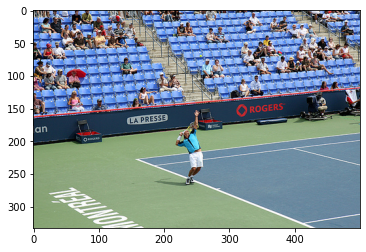

Greedy: Vận động viên tennis đang cầm vợt tennis nhảy lên đỡ bóng .
Beam Search, K = 3: Vận động viên tennis đang cầm vợt tennis nhảy lên đỡ bóng .
Beam Search, K = 5: Vận nam vận động viên tennis đang tung quả bóng lên cao để phát bóng .
Beam Search, K = 7: Vận nam vận động viên tennis đang tung quả bóng lên cao để phát bóng .


In [40]:
pic = list(encoding_test.keys())[178]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(pic)
plt.imshow(x)
plt.show()

print("Greedy:",greedySearch(image))
print("Beam Search, K = 3:",beam_search_predictions(image, beam_index = 3))
print("Beam Search, K = 5:",beam_search_predictions(image, beam_index = 5))
print("Beam Search, K = 7:",beam_search_predictions(image, beam_index = 7))

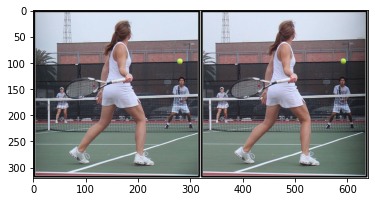

Greedy: Một người phụ nữ đang chuẩn vợt để đánh quả tennis .
Beam Search, K = 3: Một người phụ nữ đang chuẩn người để sau quả bóng tennis .
Beam Search, K = 5: Một người phụ nữ vung vợt vào một quả bóng tennis. trong hồ viên .
Beam Search, K = 7: Một vận vận động viên tennis đang thi đấu ở trên sân .


In [43]:
pic = list(encoding_test.keys())[52]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(pic)
plt.imshow(x)
plt.show()

print("Greedy:",greedySearch(image))
print("Beam Search, K = 3:",beam_search_predictions(image, beam_index = 3))
print("Beam Search, K = 5:",beam_search_predictions(image, beam_index = 5))
print("Beam Search, K = 7:",beam_search_predictions(image, beam_index = 7))